# Trabalho Final - Deep Learning and Reinforcement Learning

### Integrantes:

###    1) Jurandir Ventura - RM336634
###    2) Marcelo Preto - RM336632
###    3) Fabio Rizzi - RM336656
###    4) Thiago Alexandre – RM336583

## Redes Neurais Convolucionais

## Exercício #9 (OPCIONAL) - 2 PONTOS
### Utilizando o dataset BVMF3 (disponível em: https://www.dropbox.com/s/lbdrugh5thzvvrk/BVMF3.SA.csv?dl=0) faça uma previsão de série temporal utilizando LSTM para prever 30 dias do valor de fechamento a partir do registro #1500 do dataset.

### Instruções Gerais:
- É permitido usar outras abordagens e arquiteturas de LSTM;
- Não é permitido o uso de modelos pré-treinados;
- Faça uma boa distribuição dos dados de teste e treinamento;

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import math

from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense, Dropout
from keras.utils import np_utils
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

random_state=42
df=pd.read_csv("data/ex9-bvmf3.sa-correto.csv", delimiter=',', encoding='UTF-8')
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted', 'Day'] # Ajustando nomes das colunas
np.random.seed(random_state)

In [2]:
# Cria uma matriz com número de colunas igual a "look_back" com cada
# coluna incrementando a sequência da amostra anterior
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [3]:
df.tail()

,Open,High,Low,Close,Volume,Adjusted,Day
1623,23.389999,23.930000,23.240000,23.680000,7008800.0,23.599579,2017-11-17
1624,23.680000,23.680000,23.680000,23.680000,0.0,23.599579,2017-11-20
1625,23.870001,24.510000,23.830000,24.280001,13880900.0,24.197542,2017-11-21
1626,24.209999,24.590000,24.209999,24.490000,12842900.0,24.490000,2017-11-22
1627,24.400000,24.629999,24.059999,24.469999,2784700.0,24.469999,2017-11-23


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1602 non-null   float64
 1   High      1602 non-null   float64
 2   Low       1602 non-null   float64
 3   Close     1602 non-null   float64
 4   Volume    1602 non-null   float64
 5   Adjusted  1602 non-null   float64
 6   Day       1628 non-null   object 
dtypes: float64(6), object(1)
memory usage: 89.2+ KB


In [5]:
# Removendo coluna categórica
df.drop(columns=['Day'], inplace=True)
# Limpando nulos
df.dropna(inplace=True) # Limpando vazios

In [6]:
data = trace = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': 'BVMF3 SA',
    'showlegend': True
}

layout = go.Layout({
    'title': {
        'text': 'BVMF3 SA',
        'font': {
            'size': 15
        }
    }
})
fig = go.Figure(data=data, layout=layout)
fig.show()

In [7]:
# Vetor com valores de fechamento
X = df.loc[:, df.columns == 'Close'].values
print("5 amostras de fechamento: ")
X[:5]

5 amostras de fechamento:


array([[12.07],
       [11.8 ],
       [11.7 ],
       [11.54],
       [11.37]])

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X);
print("Amostras de fechamento normalizadas: ")
X[:5]

Amostras de fechamento normalizadas: 


array([[0.24469914],
       [0.22922636],
       [0.2234957 ],
       [0.21432665],
       [0.20458453]])

In [9]:
# Separando primeiras 1500 amostras para treinamento
periodo_a_analisar=1500
periodo_a_prever=30

train_set = X[:periodo_a_analisar]
print("Quantidade de dados de treino:", train_set.shape[0])
# Separando amostras a serem preditas
test_set = X[periodo_a_analisar+1:periodo_a_analisar+1+periodo_a_prever]
print("Quantidade de dados de teste:", test_set.shape[0])

Quantidade de dados de treino: 1500
Quantidade de dados de teste: 30


In [10]:
# reshape into X=t and Y=t+1
look_back = 3
X_train, y_train = create_dataset(train_set, look_back)
X_test, y_test = create_dataset(test_set, look_back)

In [11]:
print("* 2 amostras X_train:")
print()
print(X_train[:2])
print()
print()
print("* 2 amostras y_train:")
print()
print(y_train[:2])

* 2 amostras X_train:

[[0.24469914 0.22922636 0.2234957 ]
 [0.22922636 0.2234957  0.21432665]]


* 2 amostras y_train:

[0.21432665 0.20458453]


In [12]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
print("* 2 amostras X_train:")
print()
print(X_train[:2])
print()
print()
print("* 2 amostras y_train:")
print()
print(y_train[:2])

* 2 amostras X_train:

[[[0.24469914]
  [0.22922636]
  [0.2234957 ]]

 [[0.22922636]
  [0.2234957 ]
  [0.21432665]]]


* 2 amostras y_train:

[0.21432665 0.20458453]


In [14]:
# create and fit the LSTM network
model=Sequential()

model.add(LSTM(units = 8, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 8))
model.add(Dropout(0.1))

model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0081
Epoch 2/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0022
Epoch 3/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0016
Epoch 4/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 5/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 6/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 7/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 8/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 9/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 10/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 11/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 12/20
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0010
E

In [15]:
# predictions
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

In [16]:
# Revert predictions to original scale
y_train_predict = scaler.inverse_transform(y_train_predict)
y_train = scaler.inverse_transform([y_train])
y_test_predict = scaler.inverse_transform(y_test_predict)
y_test = scaler.inverse_transform([y_test])

In [17]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], y_train_predict[:,0]))
print("Train Score: %.2f RMSE" % (train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], y_test_predict[:,0]))
print("Test Score: %.2f RMSE" % (test_score))


Train Score: 0.36 RMSE
Test Score: 0.54 RMSE


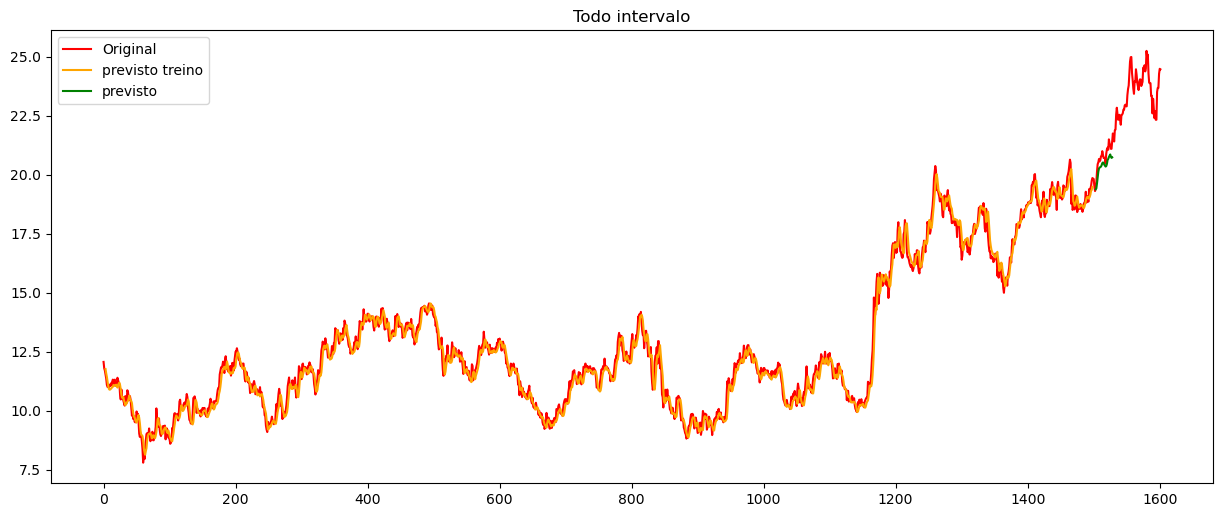

In [18]:
# shift train predictions for plotting
y_train_predict_plot = np.empty_like(X)
y_train_predict_plot[:, :] = np.nan
y_train_predict_plot[look_back:len(y_train_predict)+look_back, :] = y_train_predict

# shift test predictions for plotting
y_test_predict_plot = np.empty_like(X)
y_test_predict_plot[:, :] = np.nan
y_test_predict_plot[len(y_train_predict)+(look_back*2)+1:periodo_a_analisar+periodo_a_prever-1] = y_test_predict

# plot baseline and predictions
fig1=plt.figure(figsize=(15, 6), dpi=100)
fig1=plt.title("Todo intervalo")
fig1=plt.plot(scaler.inverse_transform(X),color= 'red', label="Original")
fig1=plt.plot(y_train_predict_plot,color='orange', label = "previsto treino")
fig1=plt.plot(y_test_predict_plot,color='green', label = "previsto")
fig1=plt.legend()
fig1=plt.show()

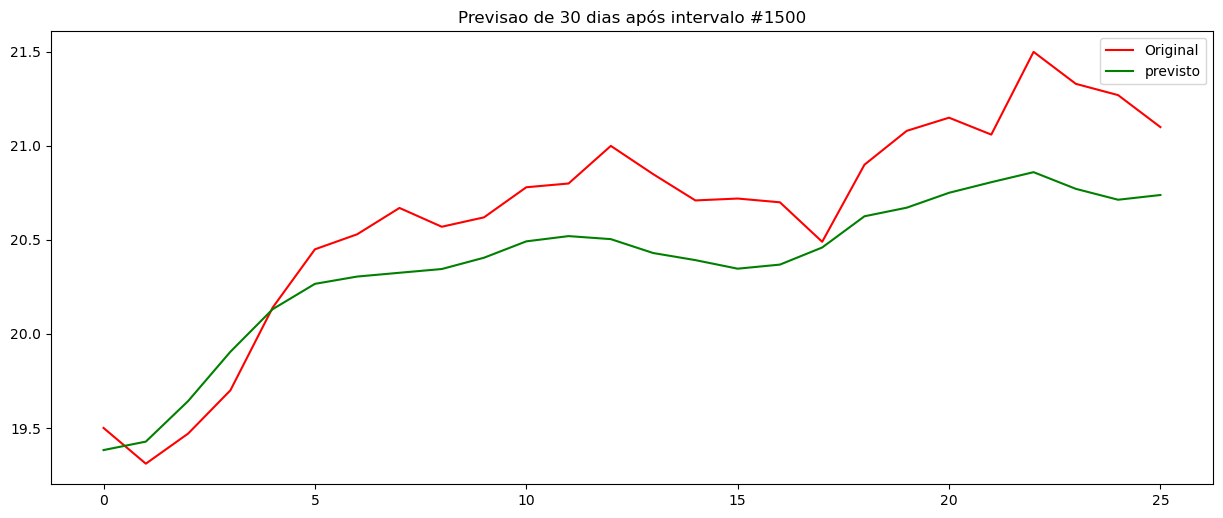

In [19]:
original=scaler.inverse_transform(X)
original_plot = np.empty_like(periodo_a_prever)
original_plot = original[periodo_a_analisar+1:periodo_a_analisar+30-look_back]

y_test_predict_plot2 = np.empty_like(periodo_a_prever)
y_test_predict_plot2 = y_test_predict

# plot baseline and predictions
fig2 = plt.figure(figsize=(15, 6), dpi=100)
fig2 = plt.title("Previsao de 30 dias após intervalo #1500")
fig2 = plt.plot(original_plot, color= 'red', label="Original")
fig2 = plt.plot(y_test_predict_plot2, color='green', label = "previsto")
fig2 = plt.legend()
fig2 = plt.show()

### *Referências:*
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://medium.com/towards-artificial-intelligence/google-stock-predictions-using-an-lstm-neural-network-dbe785949a96
- https://medium.com/alexandre-george-lustosa/previs%C3%A3o-de-pre%C3%A7o-petr4-com-python-lstm-f93722be59e0
- https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f